In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Embedding, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, Conv1D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from keras.callbacks import CSVLogger
from keras.preprocessing.sequence import pad_sequences
from matplotlib import pyplot
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from matplotlib import pyplot

Using TensorFlow backend.


In [3]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/
# convert to (records, timesteps, indicators)
def create_window_data_arrays(arrays,window_size):
    data = np.column_stack((arrays))
    arr_len = len(arrays[0])
    windows = np.array([data[i-window_size: i] for i in range(window_size +1,arr_len+1)])
    return windows


def create_window_data_array_with_shift(array,window_size, shift):
    return np.array([array[i-window_size: i] for i in range(shift +1,len(array)+1)])


In [4]:
def example_of_usage():
    future_num_predic_steps = 1
    past_steps_to_use = 4
    arr = np.array([1,2,3,4,5,6,7,8,9,10][:-future_num_predic_steps])
    arr2 = np.array([11, 12, 13, 14,15, 16,17,18,19, 20][:-future_num_predic_steps])
    Y = np.array([111,112, 113, 114,115, 116,117,118,119, 120])


    #Y = np.array([211,212, 213, 214,215, 216,217,218,219, 220])

    X = create_window_data_arrays((arr, arr2), past_steps_to_use)
    Y = create_window_data_array_with_shift(Y,future_num_predic_steps,past_steps_to_use +future_num_predic_steps)
    print(X)
    print(Y)
    print(X.shape)
    print(Y.shape)
example_of_usage()

[[[ 2 12]
  [ 3 13]
  [ 4 14]
  [ 5 15]]

 [[ 3 13]
  [ 4 14]
  [ 5 15]
  [ 6 16]]

 [[ 4 14]
  [ 5 15]
  [ 6 16]
  [ 7 17]]

 [[ 5 15]
  [ 6 16]
  [ 7 17]
  [ 8 18]]

 [[ 6 16]
  [ 7 17]
  [ 8 18]
  [ 9 19]]]
[[116]
 [117]
 [118]
 [119]
 [120]]
(5, 4, 2)
(5, 1)


In [5]:
filename_asoc = "../data/grouped_data_day_mean_tweets_sentimentdata-scraper_asociaciones_2016-2020.csv"
filename_ibex ="../data/grouped_data_day_mean_tweets_sentimentdata-scraper_ibex_2018-2020.csv"
filename_ibex_prices ="../data/ibex_historico.csv"
filename_precios_bolsa = "../data/es_mse_mean_day.csv"

df_asoc = pd.read_csv(filename_asoc, sep=";")
df_ibex = pd.read_csv(filename_ibex, sep=";")
df_ibex_prices = pd.read_csv(filename_ibex_prices, sep=",")
df_precios_bolsa = pd.read_csv(filename_precios_bolsa, sep=";")

df_x = pd.merge(left=df_asoc, right=df_ibex, left_on='normalised_date', right_on='normalised_date')
df_total = pd.merge(left=df_x, right=df_ibex_prices, left_on='normalised_date', right_on='Date')
df_total = df_total.rename(columns={"sentiment_x": "sentiment_asociacones", "sentiment_y": "sentiment_ibex"})
df_total["normalised_date"]= pd.to_datetime(df_total["normalised_date"]) 
df_total = df_total[["normalised_date","sentiment_asociacones", "sentiment_ibex", "Close"]]

df_precios_bolsa = df_precios_bolsa[["date", "price_change"]]
df_precios_bolsa["date"]= pd.to_datetime(df_precios_bolsa["date"]) 
df_total = pd.merge(left=df_total, right=df_precios_bolsa, left_on='normalised_date', right_on='date')

df_total.sentiment_asociacones = df_total.sentiment_asociacones.diff()
df_total.sentiment_ibex = df_total.sentiment_ibex.diff()
df_total.Close = df_total.Close.diff()
df_total = df_total.dropna()
df_total = df_total.rename(columns={"Close": "ibex_change", "price_change": "madrid_change"})
df_total['sentiment_asociacones'] = df_total['sentiment_asociacones'].astype(float)
df_total['sentiment_ibex'] = df_total['sentiment_ibex'].astype(float)
df_total['ibex_change'] = df_total['ibex_change'].astype(float)
df_total['madrid_change'] = df_total['madrid_change'].astype(float)

df_total = df_total[:-100]

df_total


,normalised_date,sentiment_asociacones,sentiment_ibex,ibex_change,date,madrid_change
1,2017-01-24,0.031742,-0.000420,82.400390,2017-01-24,1.260981
2,2017-01-25,-0.007774,-0.432036,162.099610,2017-01-25,1.614972
3,2017-01-26,-0.038962,0.479446,-36.500000,2017-01-26,-0.810021
4,2017-01-27,0.046862,-0.417707,-8.700196,2017-01-27,-0.140292
5,2017-01-30,-0.008826,0.478613,-142.799804,2017-01-30,-1.385265
...,...,...,...,...,...,...
741,2019-12-17,-0.021648,-0.018915,-64.699218,2019-12-17,-0.553620
742,2019-12-18,0.049066,0.003646,5.899414,2019-12-18,-0.258039
743,2019-12-19,-0.009887,-0.003893,-4.599610,2019-12-19,-0.007002
744,2019-12-20,0.090181,0.017316,58.299805,2019-12-20,0.090962


In [6]:

num_steps = 7
future_steps = 1
X_sent_asoc = df_total["sentiment_asociacones"].values[:-future_steps]
X_sent_ibex = df_total["sentiment_ibex"].values[:-future_steps]
X_ibex_prices = df_total["ibex_change"].values[:-future_steps]
X_madrid_prices = df_total["madrid_change"].values[:-future_steps]
X_madrid_prices_next = df_total["madrid_change"].values

X = np.array(create_window_data_arrays((X_sent_asoc, X_sent_ibex, X_ibex_prices,X_madrid_prices), num_steps))
#X = np.array(create_window_data_arrays((X_sent_asoc, X_sent_ibex), num_steps))
Y = create_window_data_array_with_shift(X_madrid_prices_next,future_steps, num_steps +future_steps)
print(X.shape, Y.shape)

(737, 7, 4) (737, 1)


In [7]:
train_X, test_X, train_y, test_y = train_test_split(
X, Y, test_size=0.20, shuffle=False)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(589, 7, 4) (589, 1) (148, 7, 4) (148, 1)


Train on 589 samples, validate on 148 samples
Epoch 1/250
 - 1s - loss: 4.4982 - accuracy: 0.0000e+00 - val_loss: 0.8275 - val_accuracy: 0.0000e+00
Epoch 2/250
 - 0s - loss: 2.4055 - accuracy: 0.0000e+00 - val_loss: 0.7623 - val_accuracy: 0.0000e+00
Epoch 3/250
 - 0s - loss: 1.8265 - accuracy: 0.0000e+00 - val_loss: 0.6749 - val_accuracy: 0.0000e+00
Epoch 4/250
 - 0s - loss: 1.4242 - accuracy: 0.0000e+00 - val_loss: 0.6270 - val_accuracy: 0.0000e+00
Epoch 5/250
 - 0s - loss: 1.2471 - accuracy: 0.0000e+00 - val_loss: 0.6144 - val_accuracy: 0.0000e+00
Epoch 6/250
 - 0s - loss: 1.1223 - accuracy: 0.0000e+00 - val_loss: 0.6155 - val_accuracy: 0.0000e+00
Epoch 7/250
 - 0s - loss: 1.0377 - accuracy: 0.0000e+00 - val_loss: 0.6108 - val_accuracy: 0.0000e+00
Epoch 8/250
 - 0s - loss: 0.8697 - accuracy: 0.0000e+00 - val_loss: 0.6093 - val_accuracy: 0.0000e+00
Epoch 9/250
 - 0s - loss: 0.8762 - accuracy: 0.0000e+00 - val_loss: 0.6080 - val_accuracy: 0.0000e+00
Epoch 10/250
 - 0s - loss: 0.8167 - 

Epoch 81/250
 - 0s - loss: 0.7168 - accuracy: 0.0000e+00 - val_loss: 0.6032 - val_accuracy: 0.0000e+00
Epoch 82/250
 - 0s - loss: 0.7059 - accuracy: 0.0000e+00 - val_loss: 0.6029 - val_accuracy: 0.0000e+00
Epoch 83/250
 - 0s - loss: 0.7090 - accuracy: 0.0000e+00 - val_loss: 0.6021 - val_accuracy: 0.0000e+00
Epoch 84/250
 - 0s - loss: 0.7080 - accuracy: 0.0000e+00 - val_loss: 0.6025 - val_accuracy: 0.0000e+00
Epoch 85/250
 - 0s - loss: 0.7040 - accuracy: 0.0000e+00 - val_loss: 0.6022 - val_accuracy: 0.0000e+00
Epoch 86/250
 - 0s - loss: 0.7078 - accuracy: 0.0000e+00 - val_loss: 0.6023 - val_accuracy: 0.0000e+00
Epoch 87/250
 - 0s - loss: 0.7158 - accuracy: 0.0000e+00 - val_loss: 0.6021 - val_accuracy: 0.0000e+00
Epoch 88/250
 - 0s - loss: 0.7082 - accuracy: 0.0000e+00 - val_loss: 0.6036 - val_accuracy: 0.0000e+00
Epoch 89/250
 - 0s - loss: 0.7157 - accuracy: 0.0000e+00 - val_loss: 0.6030 - val_accuracy: 0.0000e+00
Epoch 90/250
 - 0s - loss: 0.7140 - accuracy: 0.0000e+00 - val_loss: 0.60

Epoch 160/250
 - 0s - loss: 0.6943 - accuracy: 0.0000e+00 - val_loss: 0.6052 - val_accuracy: 0.0000e+00
Epoch 161/250
 - 0s - loss: 0.6778 - accuracy: 0.0000e+00 - val_loss: 0.6081 - val_accuracy: 0.0000e+00
Epoch 162/250
 - 0s - loss: 0.6920 - accuracy: 0.0000e+00 - val_loss: 0.6082 - val_accuracy: 0.0000e+00
Epoch 163/250
 - 0s - loss: 0.6843 - accuracy: 0.0000e+00 - val_loss: 0.6054 - val_accuracy: 0.0000e+00
Epoch 164/250
 - 0s - loss: 0.6831 - accuracy: 0.0000e+00 - val_loss: 0.6070 - val_accuracy: 0.0000e+00
Epoch 165/250
 - 0s - loss: 0.6882 - accuracy: 0.0000e+00 - val_loss: 0.6075 - val_accuracy: 0.0000e+00
Epoch 166/250
 - 0s - loss: 0.6823 - accuracy: 0.0000e+00 - val_loss: 0.6068 - val_accuracy: 0.0000e+00
Epoch 167/250
 - 0s - loss: 0.6734 - accuracy: 0.0000e+00 - val_loss: 0.6109 - val_accuracy: 0.0000e+00
Epoch 168/250
 - 0s - loss: 0.6774 - accuracy: 0.0000e+00 - val_loss: 0.6097 - val_accuracy: 0.0000e+00
Epoch 169/250
 - 0s - loss: 0.6894 - accuracy: 0.0000e+00 - val_

Epoch 239/250
 - 0s - loss: 0.5933 - accuracy: 0.0000e+00 - val_loss: 0.6468 - val_accuracy: 0.0000e+00
Epoch 240/250
 - 0s - loss: 0.6281 - accuracy: 0.0000e+00 - val_loss: 0.6343 - val_accuracy: 0.0000e+00
Epoch 241/250
 - 0s - loss: 0.6008 - accuracy: 0.0000e+00 - val_loss: 0.6428 - val_accuracy: 0.0000e+00
Epoch 242/250
 - 0s - loss: 0.6123 - accuracy: 0.0000e+00 - val_loss: 0.6295 - val_accuracy: 0.0000e+00
Epoch 243/250
 - 0s - loss: 0.5925 - accuracy: 0.0000e+00 - val_loss: 0.6572 - val_accuracy: 0.0000e+00
Epoch 244/250
 - 0s - loss: 0.6125 - accuracy: 0.0000e+00 - val_loss: 0.6438 - val_accuracy: 0.0000e+00
Epoch 245/250
 - 0s - loss: 0.6055 - accuracy: 0.0000e+00 - val_loss: 0.6356 - val_accuracy: 0.0000e+00
Epoch 246/250
 - 0s - loss: 0.6097 - accuracy: 0.0000e+00 - val_loss: 0.6309 - val_accuracy: 0.0000e+00
Epoch 247/250
 - 0s - loss: 0.5924 - accuracy: 0.0000e+00 - val_loss: 0.6411 - val_accuracy: 0.0000e+00
Epoch 248/250
 - 0s - loss: 0.5928 - accuracy: 0.0000e+00 - val_

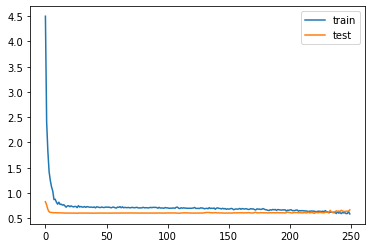

In [8]:
output_size = future_steps
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.7))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))

model.compile(loss='mae', optimizer='adam',metrics=['accuracy'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=250, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 753 samples, validate on 84 samples
Epoch 1/200
 - 0s - loss: 15.8947 - accuracy: 0.0000e+00 - mae: 15.8947 - val_loss: 1.9106 - val_accuracy: 0.0000e+00 - val_mae: 1.9106
Epoch 2/200
 - 0s - loss: 7.6644 - accuracy: 0.0000e+00 - mae: 7.6644 - val_loss: 1.3684 - val_accuracy: 0.0000e+00 - val_mae: 1.3684
Epoch 3/200
 - 0s - loss: 3.7282 - accuracy: 0.0000e+00 - mae: 3.7282 - val_loss: 0.8877 - val_accuracy: 0.0000e+00 - val_mae: 0.8877
Epoch 4/200
 - 0s - loss: 1.8107 - accuracy: 0.0000e+00 - mae: 1.8107 - val_loss: 0.6921 - val_accuracy: 0.0000e+00 - val_mae: 0.6921
Epoch 5/200
 - 0s - loss: 1.2076 - accuracy: 0.0000e+00 - mae: 1.2076 - val_loss: 0.7006 - val_accuracy: 0.0000e+00 - val_mae: 0.7006
Epoch 6/200
 - 0s - loss: 0.9977 - accuracy: 0.0000e+00 - mae: 0.9977 - val_loss: 0.6845 - val_accuracy: 0.0000e+00 - val_mae: 0.6845
Epoch 7/200
 - 0s - loss: 0.8597 - accuracy: 0.0000e+00 - mae: 0.8597 - val_loss: 0.6713 - val_accuracy: 0.0000e+00 - val_mae: 0.6713
Epoch 8/200
 - 

Epoch 62/200
 - 0s - loss: 0.8342 - accuracy: 0.0000e+00 - mae: 0.8342 - val_loss: 0.6690 - val_accuracy: 0.0000e+00 - val_mae: 0.6690
Epoch 63/200
 - 0s - loss: 0.8342 - accuracy: 0.0000e+00 - mae: 0.8342 - val_loss: 0.6696 - val_accuracy: 0.0000e+00 - val_mae: 0.6696
Epoch 64/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 65/200
 - 0s - loss: 0.8342 - accuracy: 0.0000e+00 - mae: 0.8342 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 66/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 67/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 68/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 69/200
 - 0s - loss: 0.8342 - accuracy: 0.0000e+0

Epoch 123/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 124/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 125/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 126/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 127/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 128/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 129/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 130/200
 - 0s - loss: 0.8341 - accuracy: 0

Epoch 184/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 185/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 186/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 187/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 188/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 189/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 190/200
 - 0s - loss: 0.8341 - accuracy: 0.0000e+00 - mae: 0.8341 - val_loss: 0.6697 - val_accuracy: 0.0000e+00 - val_mae: 0.6697
Epoch 191/200
 - 0s - loss: 0.8341 - accuracy: 0

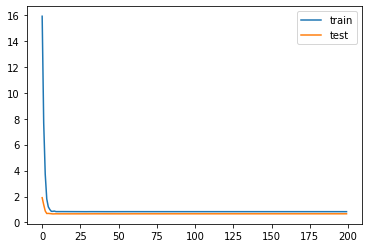

In [56]:
output_size = future_steps
n_timesteps = train_X.shape[1]
n_features = train_X.shape[2]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.7))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(output_size))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae'])
csv_logger = CSVLogger('log_loss.csv', append=False, separator=';')
# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=40, validation_data=(test_X, test_y), verbose=2, shuffle=False, callbacks=[csv_logger])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

148/148 [==============================] - 0s 65us/step
0.6646838421905588
[[ 0.86954286 -0.24009532]
 [-1.39601828 -0.14979881]
 [ 0.58549653 -0.46011177]
 [ 1.34069628 -0.73681688]
 [ 0.24460414 -0.50823337]
 [ 0.72431341 -0.26752934]
 [ 1.1221122  -0.09936469]
 [ 0.44853541 -0.32770631]
 [-0.03893214 -0.29286173]
 [-0.76622205 -0.78066361]
 [-0.12801328 -0.22048596]
 [-1.14997503  0.10679249]
 [-0.53466218 -0.10028507]
 [ 0.90272135 -0.01190982]
 [ 0.04107074 -0.03479408]
 [ 0.44078473 -0.05325744]
 [ 0.6244962  -0.08482303]
 [-0.01654669  0.14290315]
 [-0.55285152  0.20812586]
 [ 0.13690822  0.22433168]
 [-0.27714888  0.53570646]
 [ 0.52996375  0.21913126]
 [ 0.14594711 -0.26429722]
 [ 0.26213212 -0.27396634]
 [ 0.91913101 -0.03903494]
 [-0.06983997 -0.16714057]
 [-1.17093225 -0.34005818]
 [-0.59169183 -0.03159138]
 [-0.19165456  0.01423484]
 [ 0.29409784  0.00822922]
 [ 0.29395703  0.15923768]
 [ 0.20482726  0.41337913]
 [ 0.19922012  0.39831558]
 [ 0.160052    0.2662448 ]
 [-0.88

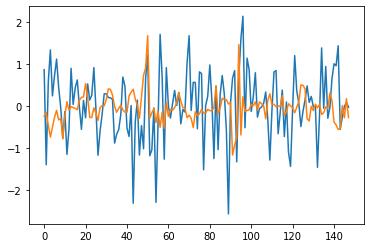

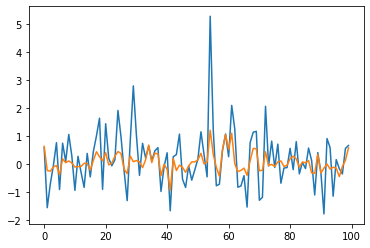

In [10]:
#https://datascience.stackexchange.com/a/45172
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred))

M = np.column_stack((test_y, y_pred))
#M_untransformed = scaler.inverse_transform(M)

#y_pred_un = scaler.inverse_transform(y_pred.reshape((len(y_pred),1)))
#test_y_un = scaler.inverse_transform(test_y.reshape((len(test_y),1)))

print(M)


print("---")
#print(M_untransformed)

#print(df_total.values[-3:])


def mean_absolute_percentage_error(y_true, y_pred): 

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

y_pred = model.predict(X, batch_size=40, verbose=1)
print(mean_absolute_error(Y, y_pred))
print(r2_score(y_pred,Y))
print(mean_absolute_percentage_error(y_pred,Y))


y_pred_test = model.predict(test_X, batch_size=40, verbose=1)
print(mean_absolute_error(test_y, y_pred_test))
print(r2_score(y_pred_test,test_y))
print(mean_absolute_percentage_error(test_y,y_pred_test))

M = np.column_stack((test_y, y_pred_test))
plot1 = plt.figure(2)
plt.plot(M)

y_pred_train = model.predict(train_X, batch_size=40, verbose=1)
print(mean_absolute_error(train_y, y_pred_train))
print(r2_score(y_pred_train,train_y))
print(mean_absolute_percentage_error(train_y,y_pred_train))

M = np.column_stack((train_y, y_pred_train))

plot1 = plt.figure(3)
plt.plot(M[:100])

plt.show()


In [20]:
def take_predecesor(y):
    y_pred = y[:-1]
    y_pred = np.insert(y_pred, 0, 0, axis=0)
    return y_pred

Y_null_model = take_predecesor(Y)

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795  0.        ]
 [-1.56814621  0.58604795]
 [-0.7183444  -1.56814621]
 [-0.05927397 -0.7183444 ]
 [ 0.75498299 -0.05927397]
 [-0.92035478  0.75498299]
 [ 0.73546661 -0.92035478]
 [ 0.08049359  0.73546661]
 [ 1.04769402  0.08049359]
 [ 0.27684574  1.04769402]]
0.9695638577249905
-0.9366773739059973
inf


/Users/hugojosebello/.local/share/virtualenvs/twitter-data-scripts-analysis-AIss9UM-/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [21]:
predecesor_1 = take_predecesor(Y)
predecesor_2 = take_predecesor(predecesor_1)

Y_null_model = (predecesor_1 + predecesor_2)/2

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795  0.        ]
 [-1.56814621  0.29302398]
 [-0.7183444  -0.49104913]
 [-0.05927397 -1.14324531]
 [ 0.75498299 -0.38880918]
 [-0.92035478  0.34785451]
 [ 0.73546661 -0.08268589]
 [ 0.08049359 -0.09244408]
 [ 1.04769402  0.4079801 ]
 [ 0.27684574  0.56409381]]
0.8329771910337289
-1.8239746260241065
inf


/Users/hugojosebello/.local/share/virtualenvs/twitter-data-scripts-analysis-AIss9UM-/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [22]:
mean = np.mean(Y)
Y_null_model = np.full(Y.shape, mean)
np.column_stack((Y, Y_null_model))

M=np.column_stack((Y, Y_null_model))
print(M[:10])

print(mean_absolute_error(Y, Y_null_model))
print(r2_score(Y_null_model,Y))
print(mean_absolute_percentage_error(Y_null_model,Y))

[[ 0.58604795  0.00922732]
 [-1.56814621  0.00922732]
 [-0.7183444   0.00922732]
 [-0.05927397  0.00922732]
 [ 0.75498299  0.00922732]
 [-0.92035478  0.00922732]
 [ 0.73546661  0.00922732]
 [ 0.08049359  0.00922732]
 [ 1.04769402  0.00922732]
 [ 0.27684574  0.00922732]]
0.69088845174642
-2.7066088913359714e+35
7487.423947115644
